In [558]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

import librosa 
import librosa.display
from sklearn.preprocessing import StandardScaler

import zipfile
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout ,Flatten , GlobalAveragePooling2D, Resizing, Rescaling
from tensorflow.keras.layers import Layer

import IPython.display as ipd


In [559]:
df = pd.read_csv('UrbanSound8K\\UrbanSound8K.csv')

In [560]:
df.shape

(8732, 8)

In [561]:
df.head(2)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing


In [564]:
df[df['slice_file_name'] == '174282-6-0-0.wav']

,slice_file_name,fsID,start,end,salience,fold,classID,class
3592,174282-6-0-0.wav,174282,0.0,2.588937,1,9,6,gun_shot


In [525]:
df['duration'] = df['end']- df['start']
df_3 = df.loc[df['duration'] > 3.0 ]

print(f'total count of  audio duration greater than 3 sec {df_3.shape[0]}')

total count of  audio duration greater than 3 sec 7468


In [539]:
example_dog_bark = 'UrbanSound8K\\fold5\\100032-3-0-0.wav'

In [541]:
tf_b = tf.constant(example_dog_bark)
audio_binary = tf.io.read_file(b)
tensor_waveform, tensor_sr = tf.audio.decode_wav(audio_binary,desired_channels=1)
tensor_waveform = tf.squeeze(tensor_waveform)

len sample and total sample_rate 7002 22050


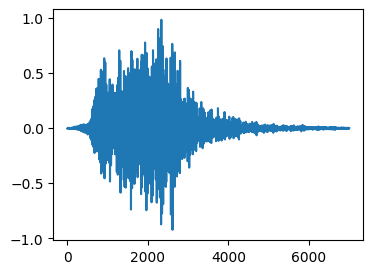

In [542]:
y , sr= librosa.load(example_dog_bark)
print('len sample and total sample_rate',len(y),sr)
plt.figure(figsize=(4,3))
plt.plot(y)
plt.show()

bank mel shape  (10, 1025)


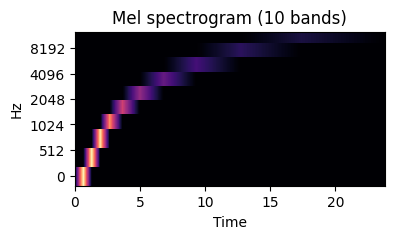

In [543]:
## Mel Bank filter 
plt.figure(figsize=(4,2))
bank_mel = librosa.filters.mel(sr=22050 , n_fft=2048,n_mels=10)
print('bank mel shape ',bank_mel.shape)
librosa.display.specshow(bank_mel, sr=22050, hop_length=512,x_axis='time', y_axis='mel')
plt.title("Mel spectrogram (10 bands)")
plt.show()

## Short time Fourier Transform Spectrogram

(1025, 219),freq_bins 1025, time_frames 219


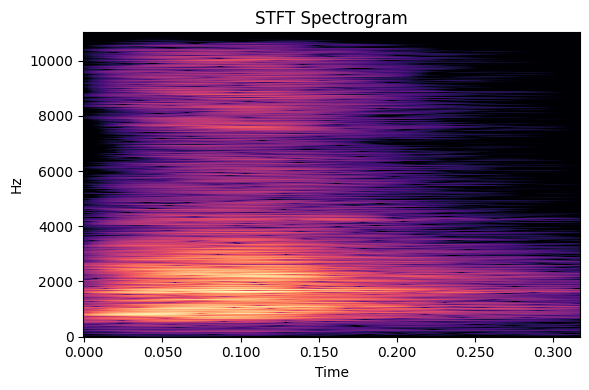

In [544]:
stft_lb = librosa.stft(y,hop_length=32)
spectrogram = np.abs(stft_lb)

stft_lb.shape ,print(f'{np.abs(stft_lb).shape},freq_bins {np.abs(stft_lb).shape[0]}, time_frames {np.abs(stft_lb).shape[1]}')

# Convert to dB scale (better visualization)
spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)

plt.figure(figsize=(6, 4))
librosa.display.specshow(spectrogram_db, sr=sr, hop_length=32,x_axis="time", y_axis="linear")
#plt.colorbar(format="%+2.0f dB")
plt.title("STFT Spectrogram")
plt.tight_layout()
plt.show()


## Mel spectrogram

mel_spectrogram shape (90, 14)
log_mel_db shape (90, 14)


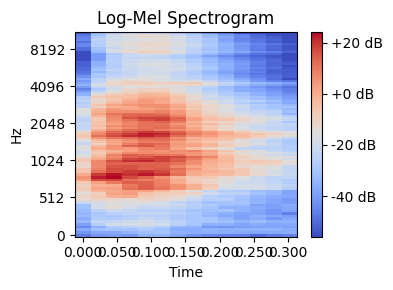

In [546]:
# Compute Mel Spectrogram
n_fft = 2048       # Frame size for FFT
hop_length = 512   # Step size between frames
n_mels = 90        # Number of Mel bands

plt.figure(figsize=(4,3))
mel_spectrogram = librosa.feature.melspectrogram(y=y,sr=sr,n_fft=n_fft,hop_length=hop_length,n_mels=n_mels)
print('mel_spectrogram shape' , mel_spectrogram.shape)
log_mel_db = librosa.power_to_db(mel_spectrogram)
print('log_mel_db shape',log_mel_db.shape)

# Plot Mel Spectrogram

librosa.display.specshow(log_mel_db, sr=sr, hop_length=512,x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Log-Mel Spectrogram")
plt.tight_layout()
plt.show()

###  Mel-Frequency Cepstral Coefficients (MFCCs)

mfccs (13, 14)


[]

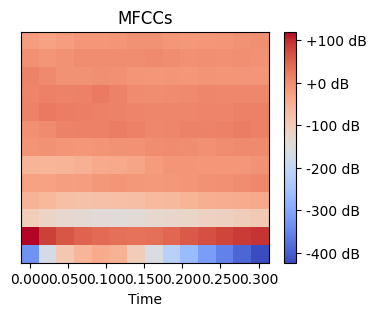

In [535]:
mfccs =librosa.feature.mfcc(y=y,sr=sr,n_mfcc=13)
print('mfccs',mfccs.shape)
# Original MFCCs
plt.figure(figsize=(4,3))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCCs')
plt.plot()

Text(0.5, 1.0, 'Delta MFCCs (1st derivative)')

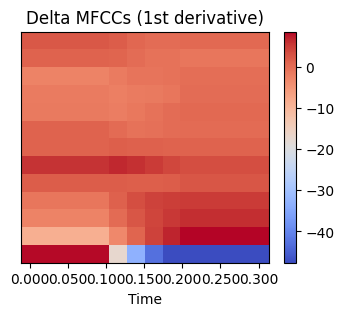

In [536]:
# First Derivative (Delta MFCCs)
plt.figure(figsize=(4,3))
delta_mfccs = librosa.feature.delta(mfccs,order=1)
librosa.display.specshow(delta_mfccs, x_axis='time', sr=sr)
plt.colorbar()
plt.title('Delta MFCCs (1st derivative)')


Text(0.5, 1.0, 'Delta-Delta MFCCs (2nd derivative)')

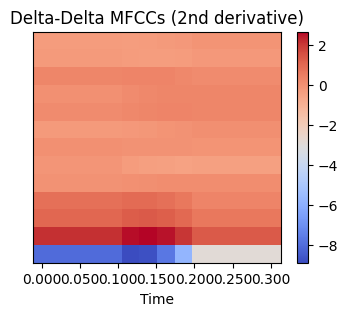

In [537]:
# Second Derivative (Delta-Delta MFCCs)
plt.figure(figsize=(4,3))
delta2_mfccs = librosa.feature.delta(delta_mfccs,order=1)
librosa.display.specshow(delta2_mfccs, x_axis='time', sr=sr)
plt.colorbar()
plt.title('Delta-Delta MFCCs (2nd derivative)')

In [547]:
## Resample the Data
def resample_data(filename, new_sr = 16000):
    y,sr = librosa.load(filename)
    resampled_audio = librosa.resample(y,orig_sr=sr,target_sr=new_sr)
    return resampled_audio , new_sr

y_resample , new_sr = resample_data(example_dog_bark)

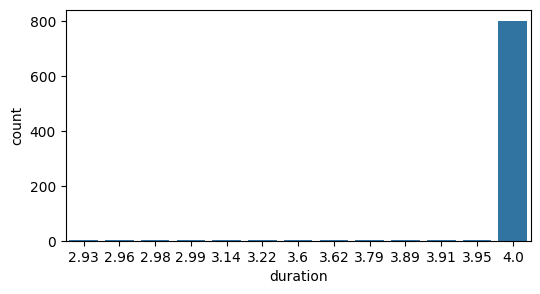

In [548]:
audio_sample_length = []
duration = []
file = 'urbansound8k\\fold3'
for i in os.listdir(file):
    filename_i = os.path.join(file,i)
    resample_i = resample_data(filename_i)[0]
    audio_sample_length.append(len(resample_i))
    duration.append(len(resample_i)/new_sr)
## Lets Check length of all data
audio_len = pd.DataFrame({'audio_sample_length':audio_sample_length , 'duration':duration})
plt.figure(figsize=[6,3])
count_df = audio_len.query("duration > 2.9")['duration'].value_counts().reset_index().round(2)
sns.barplot(data=count_df ,x='duration',y='count')
plt.show()

In [549]:
audio_len.describe().round(1)

,audio_sample_length,duration
count,925.0,925.0
mean,58765.1,3.7
std,14587.7,0.9
min,1551.0,0.1
25%,64000.0,4.0
50%,64000.0,4.0
75%,64000.0,4.0
max,64000.0,4.0


In [550]:

## Paddig the audio data
def padding_truncate(filename , duration = 4.0):
    y_resample , new_sr = resample_data(filename)
    target_len = int(new_sr*duration)
    y_re_pad = y_resample[:target_len]


    if target_len > len(y_resample) :
        #print('required padding')
        pad = np.pad(y_re_pad,pad_width=(0,target_len - len(y_resample)),mode='constant')
        return pad ,new_sr
        
    return y_re_pad ,new_sr

    


In [551]:
y_re_pad ,new_sr = padding_truncate(example_dog_bark)

In [552]:
y_re_pad , new_sr

(array([-0.00310101, -0.00509457, -0.00469933, ...,  0.        ,
         0.        ,  0.        ], shape=(64000,), dtype=float32),
 16000)

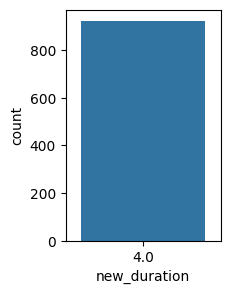

In [553]:
new_length = []
new_duration = []
for i in os.listdir(file):
    filename_i = os.path.join(file,i)
    resample_i = padding_truncate(filename_i)[0]
    new_length.append(len(resample_i))
    new_duration.append(len(resample_i)/new_sr)

audio_len['new_sample_length'] = new_length
audio_len['new_duration'] = new_duration

plt.figure(figsize=(2,3))
new_count_df = audio_len.query("new_duration > 2.9")['new_duration'].value_counts().reset_index().round(1)
sns.barplot(data=new_count_df,x='new_duration',y='count')
plt.show()

### MFCC anfter resample data  

shape of mfccs (13, 10)


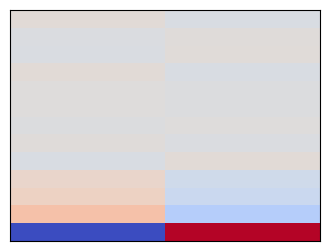

In [554]:
plt.figure(figsize=(4,3))
mfccs =librosa.feature.mfcc(y=y_resample,sr=new_sr,n_mfcc=13)
print('shape of mfccs',mfccs.shape)
## first derivative
delta_mfccs = librosa.feature.delta(mfccs)
## second derivative 
delta2_mfccs = librosa.feature.delta(delta_mfccs,order=2)
librosa.display.specshow(delta2_mfccs)
plt.show()

combined_mfccs (39, 10)


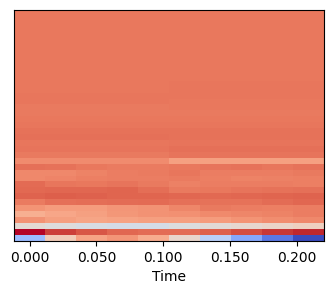

In [555]:
## Concatenate Data  
plt.figure(figsize=(4,3))
combined_mfccs = np.vstack([mfccs, delta_mfccs, delta2_mfccs])
print('combined_mfccs',combined_mfccs.shape)
librosa.display.specshow(combined_mfccs,x_axis='time')
#plt.imshow(combined_mfccs)
plt.show()

shape of scaled_feature (39, 10)


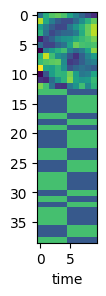

In [556]:
## rescale the Data 
plt.figure(figsize=(4,3))
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_mfccs.T).T
print('shape of scaled_feature',scaled_features.shape)
plt.imshow(scaled_features)
plt.xlabel('time')
plt.show()
